In [5]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from lavis.models import load_model_and_preprocess
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image, deprocess_image
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, \
    AblationCAM, XGradCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


methods = {"gradcam": GradCAM,
           "scorecam": ScoreCAM,
           "gradcam++": GradCAMPlusPlus,
           "xgradcam": XGradCAM,"eigencam": EigenCAM,
           "ablationcam": AblationCAM,"fullgrad": FullGrad,
           "eigengradcam": EigenGradCAM,"layercam": LayerCAM}

RESIZE_DIM = 256


In [6]:
class ImageClassifier(torch.nn.Module):
    def __init__(self, label):
        super(ImageClassifier, self).__init__()
        self.itm_model, self.itm_vis, _ = load_model_and_preprocess(name="blip2_image_text_matching",
                                                        model_type="pretrain", is_eval=True,
                                                        device=device)
        self.label = label

    def forward(self, img):
        
        print(img.shape)
        
        outputs = self.itm_model({
            "image"     : self.itm_vis["eval"](img).unsqueeze(0).to(device),
            "text_input": self.label
        }, match_head="itm")

        prob = outputs.softmax(dim=1)
        print(prob)
        return prob

In [7]:
# model.itm_model

In [8]:
def reshape_transform(input_tensor, height=16, width=16):
    remove_cls_token = 0
    if input_tensor.shape[1] == (height*width)+1:
        remove_cls_token = 1

    input_tensor = input_tensor[:, remove_cls_token:, :].reshape(input_tensor.size(0),
                                    height, width, input_tensor.size(2))


    # Bring the channels to the first dimension, like in CNNs.
    input_tensor = input_tensor.transpose(2, 3).transpose(1, 2)
    return torch.tensor(input_tensor,dtype=torch.float32,device=device)

#Load image and text
label = "Motorcyclist seriously injured in Xewkija crash"
orig_img = cv2.imread(os.path.join("..","imgs","ambulance.jpg"), 1)[:, :, ::-1]

orig_h, orig_w, _ = orig_img.shape #Keep track of the original dimension to rescale the mask on
img = cv2.resize(orig_img, (RESIZE_DIM,RESIZE_DIM))
input_tensor = preprocess_image(img, mean=None,std=None).to(device)

#This is needed otherwise pytorch_grad_cam\activations_and_gradients.py:29 prevents recording of tensor gradients
input_tensor.requires_grad_()

model = ImageClassifier(label).to(device).eval()


targets = [
    # model.itm_model.visual_encoder.blocks[-1].norm1, #Try and find the right layers for this
    # model.itm_model.Qformer.cls.predictions.transform.LayerNorm,
    model.itm_model.Qformer.bert.encoder.layer[ 0 ].crossattention.self.value,
    # model.itm_model.Qformer.bert.encoder.layer[-2 ].crossattention.self.value,
    # model.itm_model.Qformer.bert.encoder.layer[-4 ].crossattention.self.value,
    # model.itm_model.Qformer.bert.encoder.layer[-6 ].crossattention.self.value,
    # model.itm_model.Qformer.bert.encoder.layer[-8 ].crossattention.self.value,
    # model.itm_model.Qformer.bert.encoder.layer[-10].crossattention.self.value,
]

method = "gradcam++"
cam = methods[method](
    model=model,
    target_layers=targets,
    reshape_transform=reshape_transform
)

In [31]:
orig_img.shape

cv2.resize(grayscale_cam[0], (orig_h,orig_w))[:, :, np.newaxis].shape
# grayscale_cam.shape


(1199, 799, 1)

torch.Size([3, 256, 256])
tensor([[0.9073, 0.0927]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


C:\Users\User\AppData\Local\Temp\ipykernel_19636\1303468380.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input_tensor,dtype=torch.float32,device=device)


(1, 256, 256) (256, 256, 3)


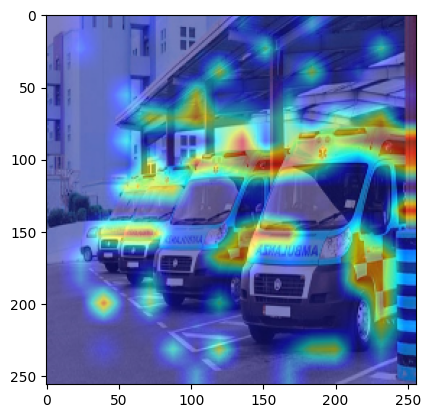

In [15]:
import matplotlib.pyplot as plt

#Get heatmap, overlay on image, and save
cam.batch_size = 128
input_tensor.requires_grad_()
grayscale_cam = cam(input_tensor=input_tensor,
                    targets=None,
                    eigen_smooth=True,
                    aug_smooth=False)


print(grayscale_cam.shape,img.shape)

cam_image = show_cam_on_image(np.float32(img) / 255, grayscale_cam[0, :],image_weight=0.5)
plt.imshow(cv2.cvtColor(cam_image,cv2.COLOR_BGR2RGB))
